# Importing Libraries

In [363]:
!pip install torchmetrics
!pip install skorch

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement 

In [364]:
import torch
from torch.optim import Adam, SGD, RAdam
from torch import nn, utils, save, load
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy, Precision, Recall
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

# Downloading the Dataset


The dataset used in the "Neural Networks and Deep Learning" by Michale Nielsen was organized as a zip of tuples
each tuple of length 2 represents: as the first element a 2d ndarray with (784, 1) shape, which represents a flattened (28x28) image,
the second element a nd array with (10, 1) which represents the value (the digit represented) of that image input,
the index where the number 1 is placed is the correct output
Given this context, we are not going to use the dataset given in the book, we've chosen to proceed using the mnist dataset from pytorch datasets.


In [70]:
# Transform PIL image into a tensor. The values are in the range [0, 1]
t = transforms.ToTensor()

# Load datasets for both training and testing.
mnist_training_28 = datasets.MNIST(root='/tmp/mnist', train=True, download=True, transform=t)
mnist_test_28 = datasets.MNIST(root='/tmp/mnist', train=False, download=True, transform=t)

In [8]:
# Transform PIL image into a tensor. The values are in the range [0, 1]
# Upsampling to 224x224 images, not a really wise strategy, just for experimentation purposes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets for both training and testing.
mnist_training_224 = datasets.MNIST(root='/tmp/mnist', train=True, download=True, transform=transform)
mnist_test_224 = datasets.MNIST(root='/tmp/mnist', train=False, download=True, transform=transform)

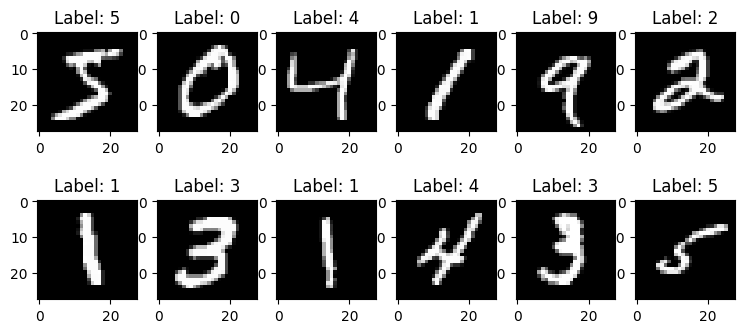

In [4]:
# Viewing the dataset
cols = 6
rows = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(1.5*cols, 2*rows))

for i, ax in enumerate(axes.flatten()):
    image, label = mnist_training_28[i]
    ax.set_title(f"Label: {label}")
    ax.imshow(image.squeeze(0), cmap='gray')  # remove first dimension, hence it its a (1, 28, 28) tensor

plt.show()

# Helper Functions

In [71]:
#tensors shape summarizer function
def layer_summary(net, input_shape):
  X = torch.randn(*input_shape)
  for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

# LeNet

LeNet was one of the first architecture of covolutional neural networks, implemented around the 90's. It consisted in 2 convolutional layers, both followed by a average pooling layer, and 3 fully connected layers after those two convolutional.

## Original

In [25]:
class LeNet(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(120), nn.Sigmoid(),
      nn.LazyLinear(84), nn.Sigmoid(),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)


In [28]:
model = LeNet(10)
layer_summary(model.net, (1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### Training

In [29]:
#Instance of the model
model_le = LeNet(10)
opt = Adam(model_le.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

In [30]:
losses_le = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader:
    predictions = model_le(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt.zero_grad()
    loss.backward()
    opt.step()

    losses_le.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.7649948596954346
Epoch 1: Loss = 0.4018377363681793
Epoch 2: Loss = 0.21679364144802094
Epoch 3: Loss = 0.09231816977262497
Epoch 4: Loss = 0.1377146691083908
Epoch 5: Loss = 0.1068335771560669
Epoch 6: Loss = 0.04822857305407524
Epoch 7: Loss = 0.09253766387701035
Epoch 8: Loss = 0.047453682869672775
Epoch 9: Loss = 0.027983592823147774


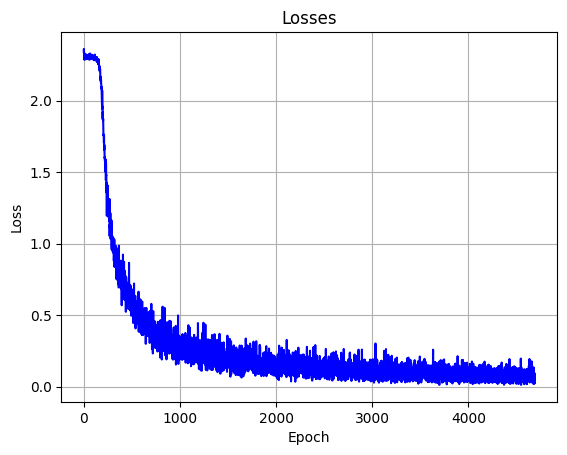

In [31]:
#Plot losses
plt.plot(losses_le, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [32]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9779


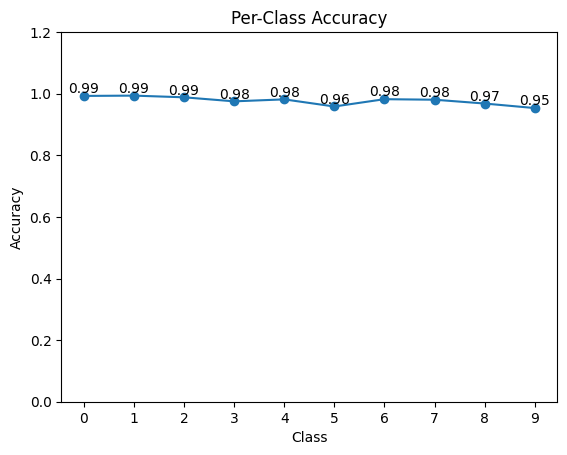

In [33]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision
Measures the accuracy of the positive predictions made by the model.

It can be described as: true positives / (true positives + false positives)

In [34]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

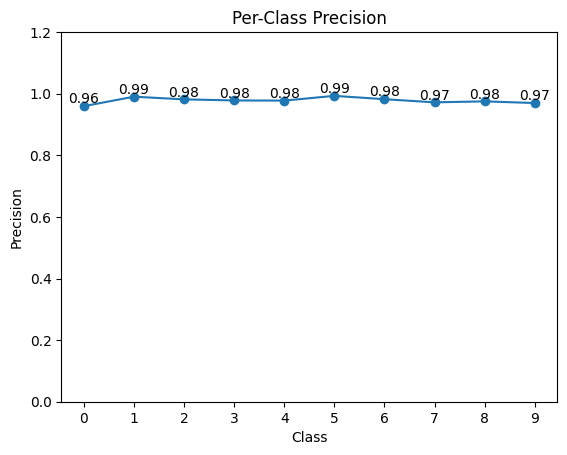

In [35]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall
Measures the ability of the model to predict positive samples correctly

It can be described as: true positives / (true positives + false negatives)

In [36]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

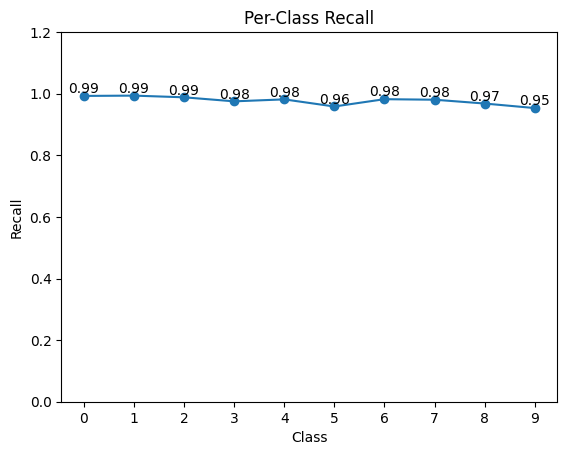

In [37]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

## Max Pool

- great impact just by changing this layer -> captures more accurately the features of each image
- implement

In [5]:
class LeNet_2(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(120), nn.Sigmoid(),
      nn.LazyLinear(84), nn.Sigmoid(),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

### Training

In [16]:
#Instance of the model
model_le_2 = LeNet_2(10)
opt_2 = Adam(model_le_2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_2 = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
losses_le_2 = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_2:
    predictions = model_le_2(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_2.zero_grad()
    loss.backward()
    opt_2.step()

    losses_le_2.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.5613201260566711
Epoch 1: Loss = 0.3517283499240875
Epoch 2: Loss = 0.19629639387130737
Epoch 3: Loss = 0.17280834913253784
Epoch 4: Loss = 0.05735485628247261
Epoch 5: Loss = 0.11811157315969467
Epoch 6: Loss = 0.09954986721277237
Epoch 7: Loss = 0.03479166701436043
Epoch 8: Loss = 0.04983021691441536
Epoch 9: Loss = 0.04268287122249603


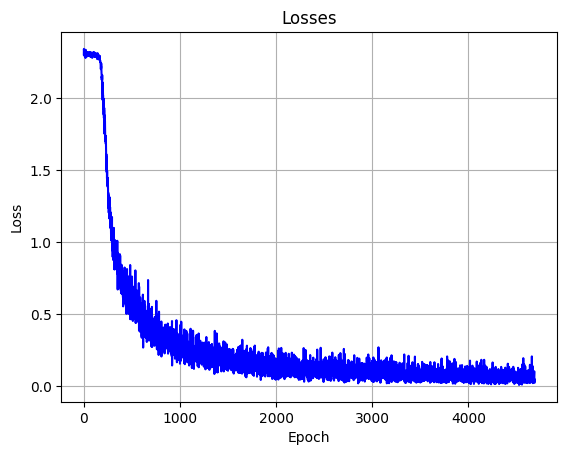

In [18]:
#Plot losses
plt.plot(losses_le_2, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [19]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates tahe results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le_2(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9821


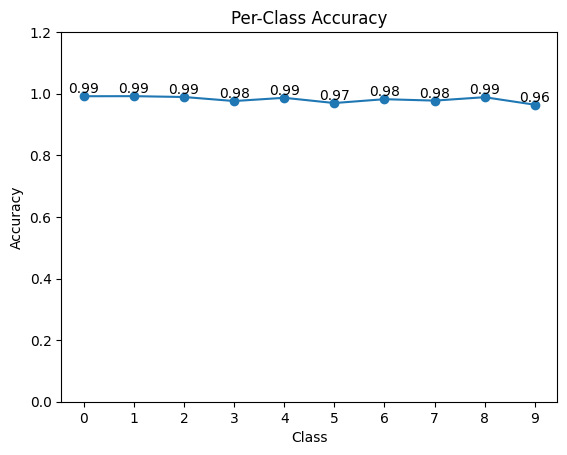

In [20]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision

In [21]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

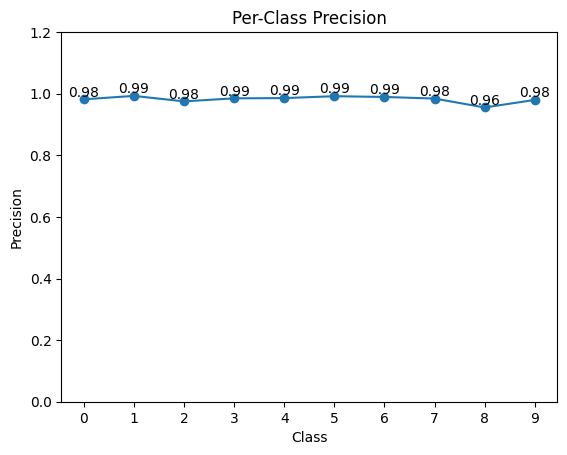

In [22]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall


In [23]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

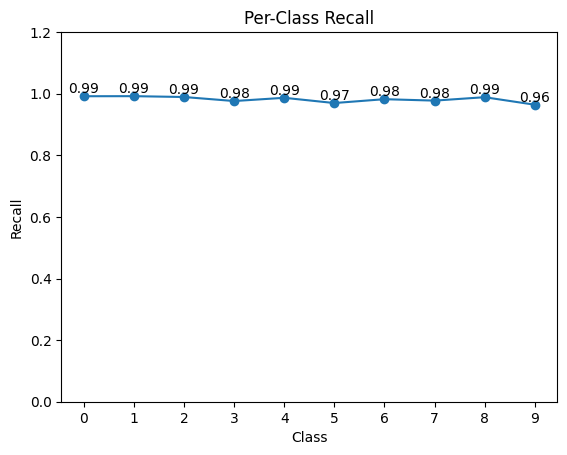

In [24]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

## Drop-out

- by adding this layer and not changing any of the other parameters the results got a little worse, the deactivation of the neurons caused a little trouble on converging mainly on the early stages
- maybe in deeper architectures, which tend to overfit, causes a greater impact
- altering the probability caused it to converge sooner
- the minimum loss reached is higher than the other alternatives above
- get the dropout probability under 0.3 didn't seem reasonable, why to even have a dropout, if the probability is so low?
- as the net did not show signs of overfitting, dont think is worth it

In [46]:
class LeNet_3(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(120), nn.Sigmoid(), nn.Dropout(p=0.3),
      nn.LazyLinear(84), nn.Sigmoid(),  nn.Dropout(p=0.3),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

### Training

In [47]:
#Instance of the model
model_le_3 = LeNet_3(10)
opt_3 = Adam(model_le_3.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_3 = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

In [48]:
losses_le_3 = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_3:
    predictions = model_le_3(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_3.zero_grad()
    loss.backward()
    opt_3.step()

    losses_le_3.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.7316508293151855
Epoch 1: Loss = 0.5158953070640564
Epoch 2: Loss = 0.20886211097240448
Epoch 3: Loss = 0.23376573622226715
Epoch 4: Loss = 0.10861582309007645
Epoch 5: Loss = 0.21049080789089203
Epoch 6: Loss = 0.2063262015581131
Epoch 7: Loss = 0.17304576933383942
Epoch 8: Loss = 0.16245603561401367
Epoch 9: Loss = 0.07186199724674225


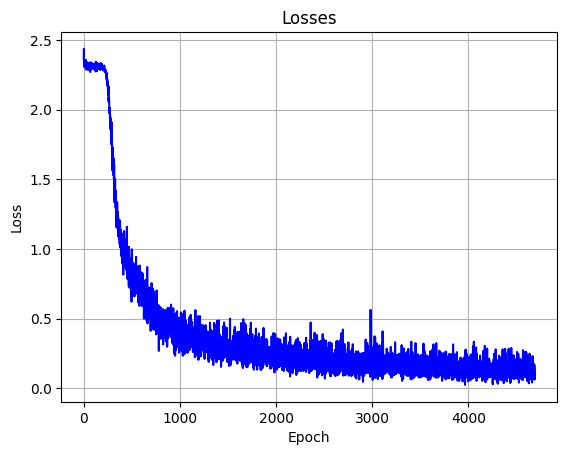

In [49]:
#Plot losses
plt.plot(losses_le_3, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [50]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le_3(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9655


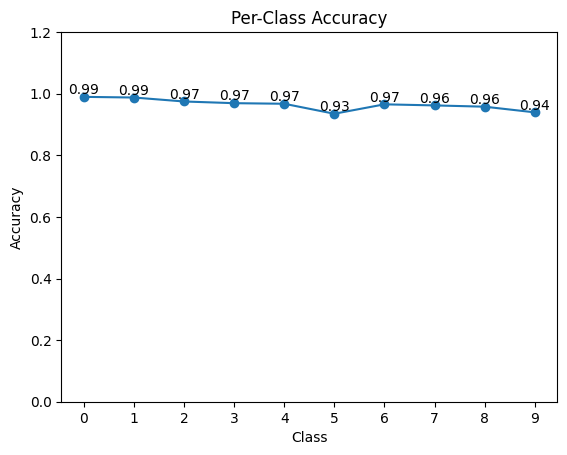

In [51]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision

In [52]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

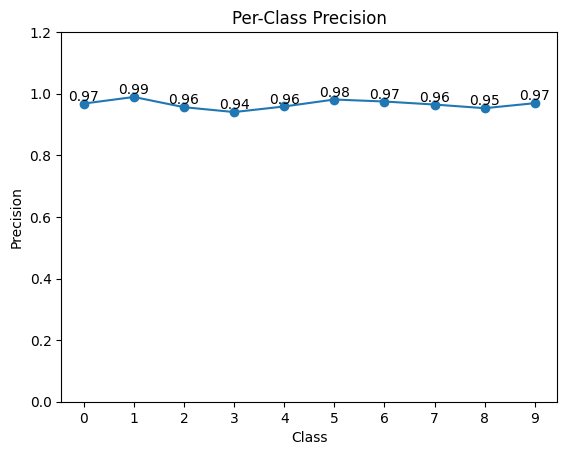

In [53]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall

In [54]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

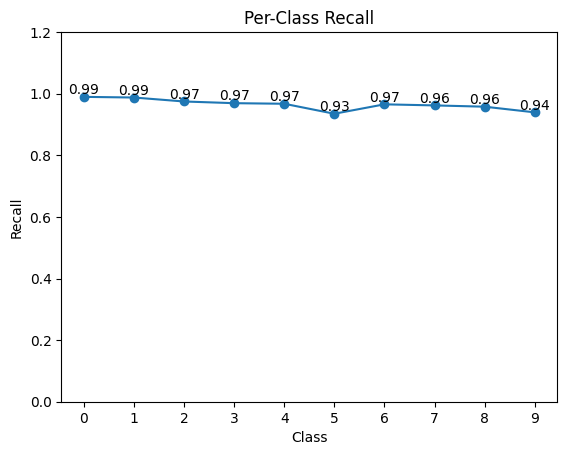

In [55]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

## ReLU

- converges really rapidily
- improved results just by altering this parameters
- implement

In [56]:
class LeNet_4(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(120), nn.ReLU(),
      nn.LazyLinear(84), nn.ReLU(),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

### Training

In [57]:
#Instance of the model
model_le_4 = LeNet_4(10)
opt_4 = Adam(model_le_4.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_4 = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [58]:
losses_le_4 = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_4:
    predictions = model_le_4(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_4.zero_grad()
    loss.backward()
    opt_4.step()

    losses_le_4.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.15172699093818665
Epoch 1: Loss = 0.09294965863227844
Epoch 2: Loss = 0.058809101581573486
Epoch 3: Loss = 0.08038049191236496
Epoch 4: Loss = 0.06176978722214699
Epoch 5: Loss = 0.038697946816682816
Epoch 6: Loss = 0.02457713894546032
Epoch 7: Loss = 0.05022801458835602
Epoch 8: Loss = 0.08752722293138504
Epoch 9: Loss = 0.040534574538469315


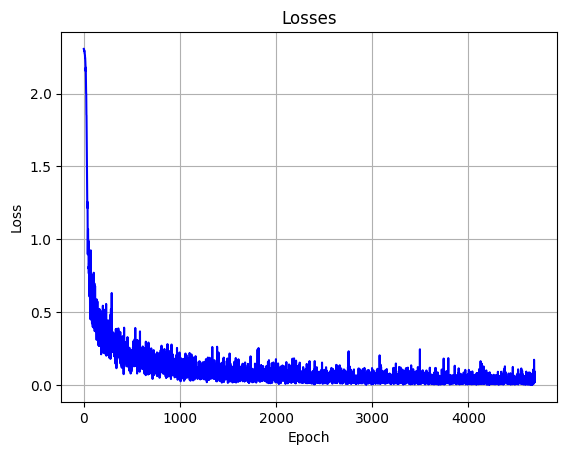

In [59]:
#Plot losses
plt.plot(losses_le_4, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [60]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le_4(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9871


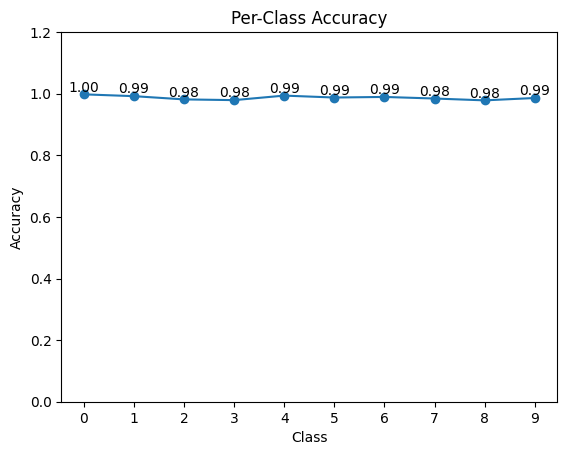

In [61]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision

In [62]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

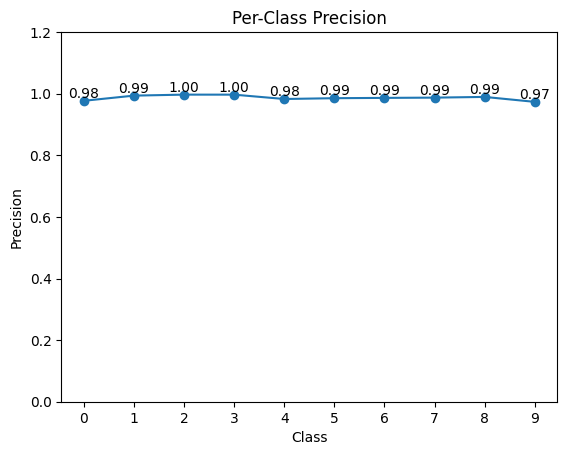

In [63]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall

In [64]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

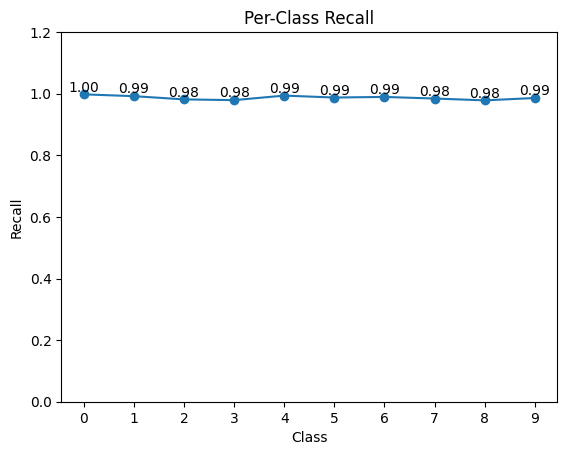

In [65]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

## Widening + Deepening

- creating another linear layer and increasing the size of the other linear layer made the loss function decrease in a good pace -> the accuracy wasn't that good
- adding another layer but not making any of them wider -> not much improvements
- making them wider -> a little improvement
- the linear part is proving not to be of such importance for the network, no real big change in the results -> not better not worse
- adding another convolutional layer + avg pool -> gotta be aware of the sizes, not all setting can provide correct output size -> layer summary for details -> no much improvement
- double size (wide)

In [201]:
class LeNet_5(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(240), nn.Sigmoid(),
      nn.LazyLinear(168), nn.Sigmoid(),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

In [202]:
model = LeNet_5(10)
layer_summary(model.net, (1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 240])
Sigmoid output shape:	 torch.Size([1, 240])
Linear output shape:	 torch.Size([1, 168])
Sigmoid output shape:	 torch.Size([1, 168])
Linear output shape:	 torch.Size([1, 10])


### Training

In [203]:
#Instance of the model
model_le_5 = LeNet_5(10)
opt_5 = Adam(model_le_5.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_5 = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

In [204]:
losses_le_5 = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_5:
    predictions = model_le_5(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_5.zero_grad()
    loss.backward()
    opt_5.step()

    losses_le_5.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.4860231876373291
Epoch 1: Loss = 0.23280960321426392
Epoch 2: Loss = 0.13342289626598358
Epoch 3: Loss = 0.24539734423160553
Epoch 4: Loss = 0.17367522418498993
Epoch 5: Loss = 0.17053775489330292
Epoch 6: Loss = 0.09566172957420349
Epoch 7: Loss = 0.095164954662323
Epoch 8: Loss = 0.1973138004541397
Epoch 9: Loss = 0.08099540323019028


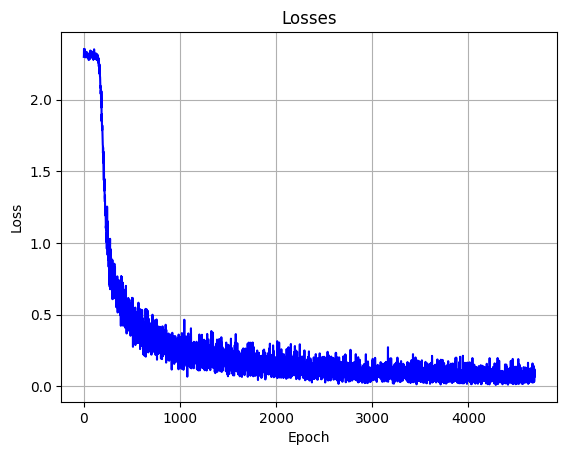

In [205]:
#Plot losses
plt.plot(losses_le_5, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [206]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le_5(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9732


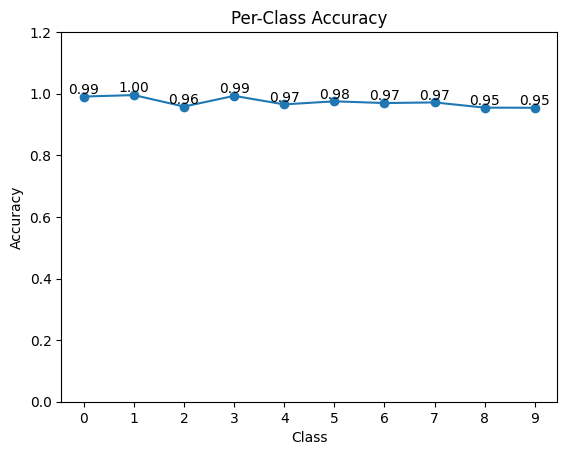

In [207]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision

In [208]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

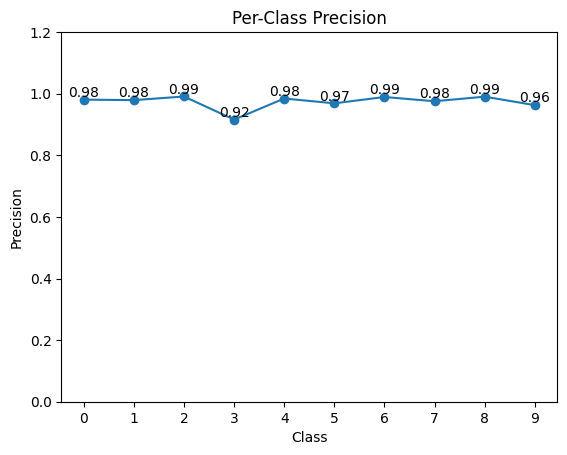

In [209]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall

In [210]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

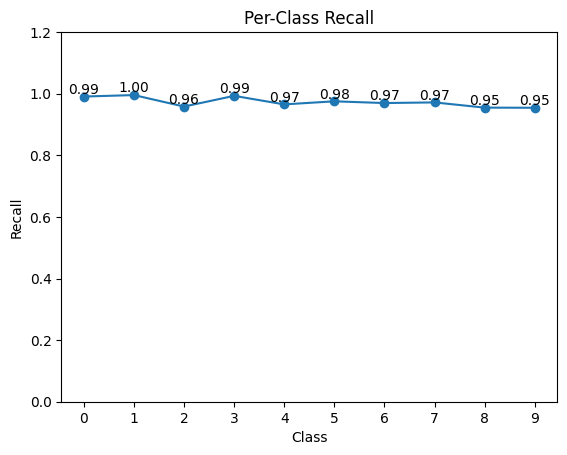

In [211]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

## Stride

- default stride in lenet is 1
- increased only to 2 to avoid loss of info, but still caused the loss to not minimize as well -> 73% accuracy
- bigger stride causes accuracy to decrease
- increasing stride on the avg pooling layer -> perfomance loss -> 88%
- deacresing stride on avg pool -> more time to train + perfomance loss -> underfit
- maintain


In [212]:
class LeNet_6(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2, stride=2), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5, stride=2), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(120), nn.Sigmoid(),
      nn.LazyLinear(84), nn.Sigmoid(),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

### Training

In [213]:
#Instance of the model
model_le_6 = LeNet_6(10)
opt_6 = Adam(model_le_6.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_6 = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [214]:
losses_le_6 = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_6:
    predictions = model_le_6(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_6.zero_grad()
    loss.backward()
    opt_6.step()

    losses_le_6.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 1.9969347715377808
Epoch 1: Loss = 1.8028396368026733
Epoch 2: Loss = 1.4507489204406738
Epoch 3: Loss = 1.404270052909851
Epoch 4: Loss = 0.9980670809745789
Epoch 5: Loss = 0.8255504965782166
Epoch 6: Loss = 0.8488919734954834
Epoch 7: Loss = 0.8454756736755371
Epoch 8: Loss = 0.9234871864318848
Epoch 9: Loss = 0.7461852431297302


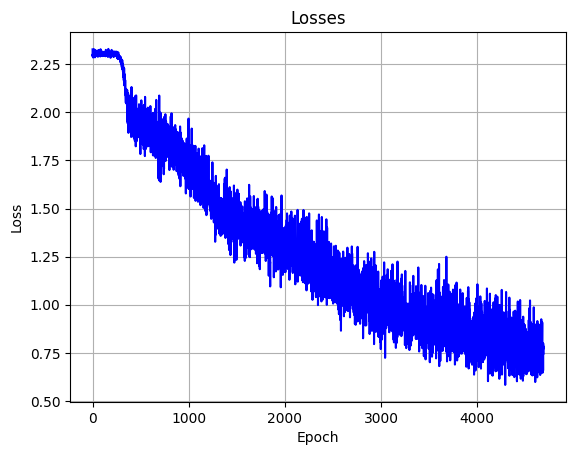

In [215]:
#Plot losses
plt.plot(losses_le_6, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [216]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le_6(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.7524


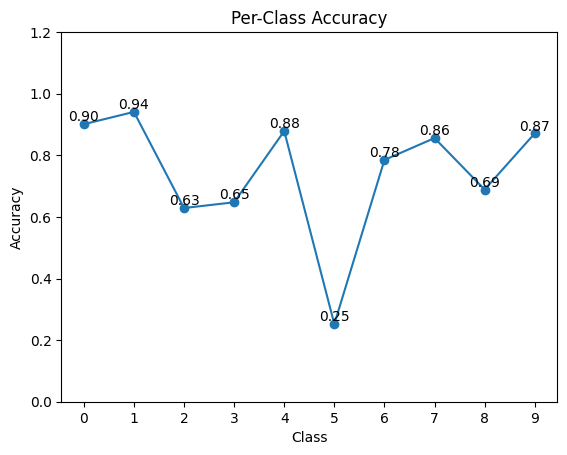

In [217]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision

In [218]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

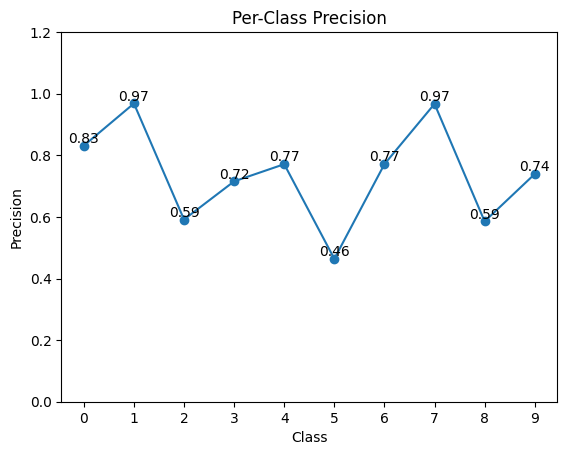

In [219]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall

In [220]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

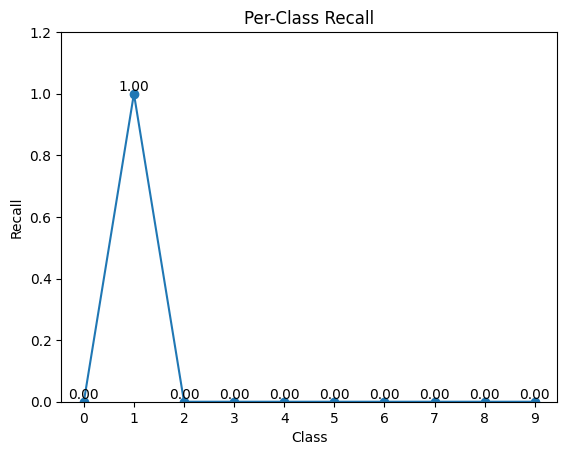

In [130]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

## Kernel size

- decreasing kernel size on convolutional layers, decreased padding so that the image maintan its shape -> average -> maintained the accuracy
- increasing kernel size on convolutional layers -> average results -> maintained
- increasing kernel size on avgpool -> too large caused perfomance downgrade
- decreasing kernel size on avgpool -> a little improvement, not as big as othr alternatives
- maintain

In [273]:
class LeNet_7(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=1, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
      nn.AvgPool2d(kernel_size=1, stride=2),
      nn.Flatten(),
      nn.LazyLinear(120), nn.Sigmoid(),
      nn.LazyLinear(84), nn.Sigmoid(),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

### Training

In [274]:
#Instance of the model
model_le_7 = LeNet_7(10)
opt_7 = Adam(model_le_7.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_7 = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

In [275]:
losses_le_7 = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_7:
    predictions = model_le_7(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_7.zero_grad()
    loss.backward()
    opt_7.step()

    losses_le_7.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.4910005033016205
Epoch 1: Loss = 0.24541683495044708
Epoch 2: Loss = 0.0808057114481926
Epoch 3: Loss = 0.15704628825187683
Epoch 4: Loss = 0.10931051522493362
Epoch 5: Loss = 0.09514015167951584
Epoch 6: Loss = 0.07569289952516556
Epoch 7: Loss = 0.09446074813604355
Epoch 8: Loss = 0.09900909662246704
Epoch 9: Loss = 0.007805675268173218


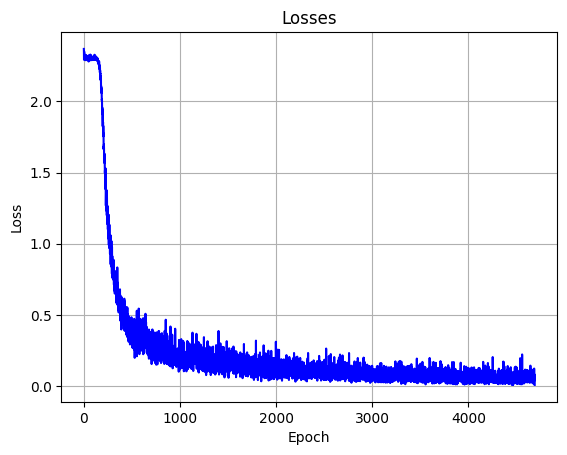

In [276]:
#Plot losses
plt.plot(losses_le_7, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [277]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates the results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le_7(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9794


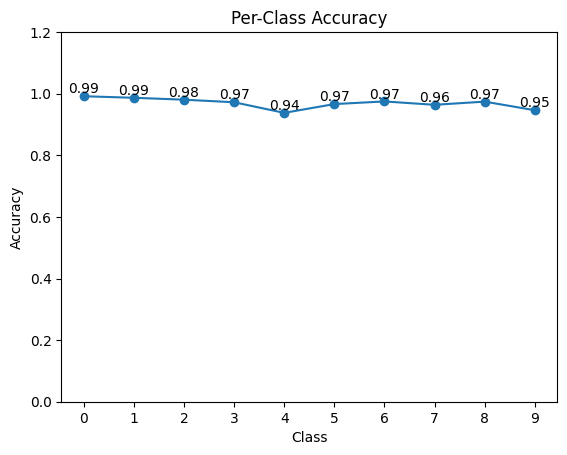

In [246]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision

In [247]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

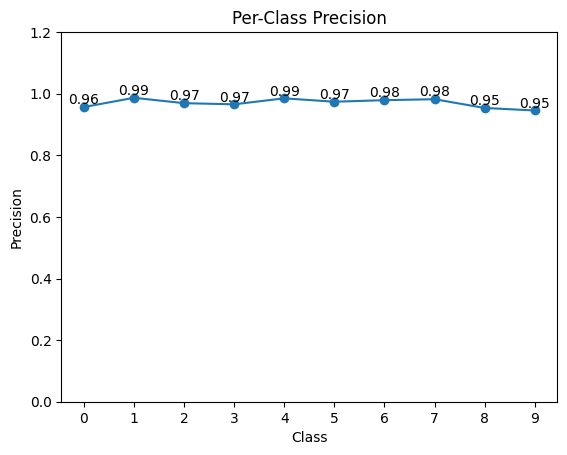

In [248]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall

In [249]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

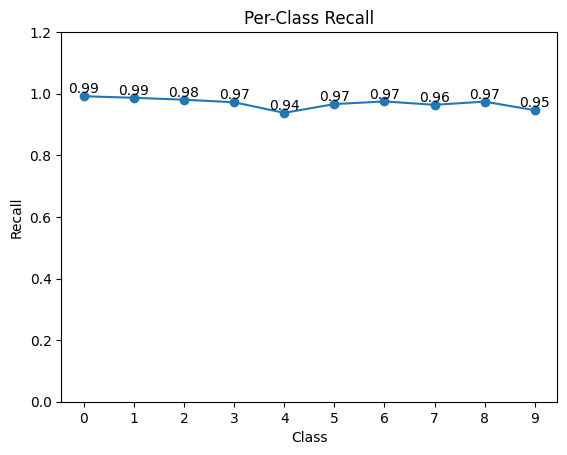

In [250]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

## Best alternative

- comparing the strategies above, those were the choices for the best accuracy and loss minimization
- decreases the loss function very rapidily, gets to a really low value, still maintain accuracy

In [278]:
class LeNet_final(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.LazyLinear(240), nn.ReLU(),
      nn.LazyLinear(168), nn.ReLU(),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

### Training

In [279]:
#Instance of the model
model_le_final = LeNet_final(10)
opt_final = Adam(model_le_final.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_final = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [280]:
losses_le_final = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_final:
    predictions = model_le_final(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_final.zero_grad()
    loss.backward()
    opt_final.step()

    losses_le_final.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.1399085372686386
Epoch 1: Loss = 0.04395197331905365
Epoch 2: Loss = 0.0630800724029541
Epoch 3: Loss = 0.03538263961672783
Epoch 4: Loss = 0.0017407393315806985
Epoch 5: Loss = 0.0114285284653306
Epoch 6: Loss = 0.05170641839504242
Epoch 7: Loss = 0.0028074102010577917
Epoch 8: Loss = 0.035961516201496124
Epoch 9: Loss = 0.0028267877642065287


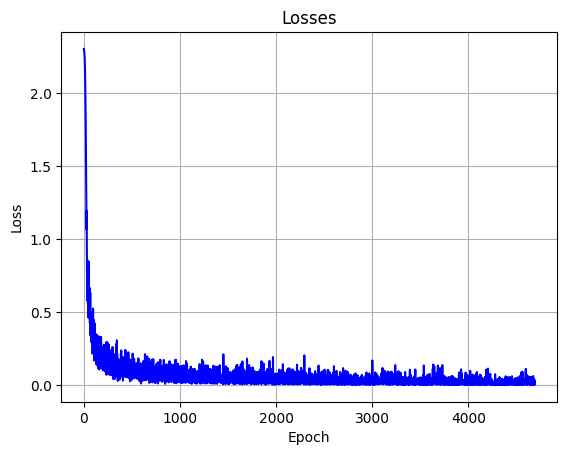

In [281]:
#Plot losses
plt.plot(losses_le_final, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [282]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates tahe results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le_final(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9898


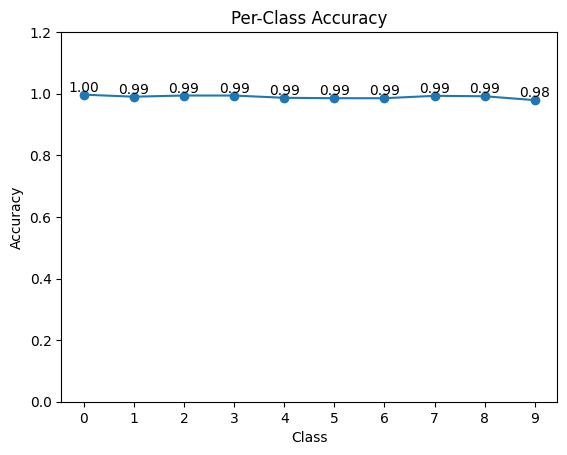

In [283]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision


In [284]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

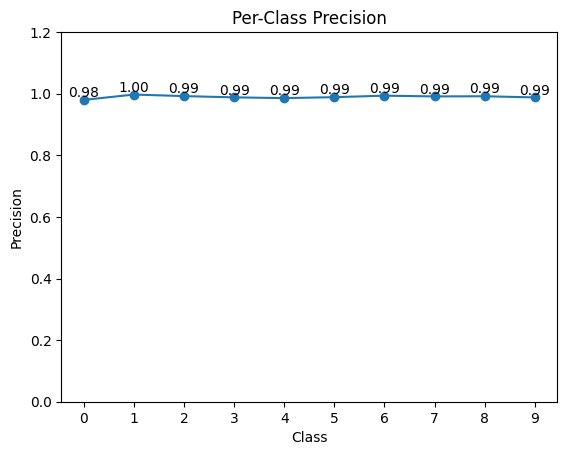

In [285]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall

In [286]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

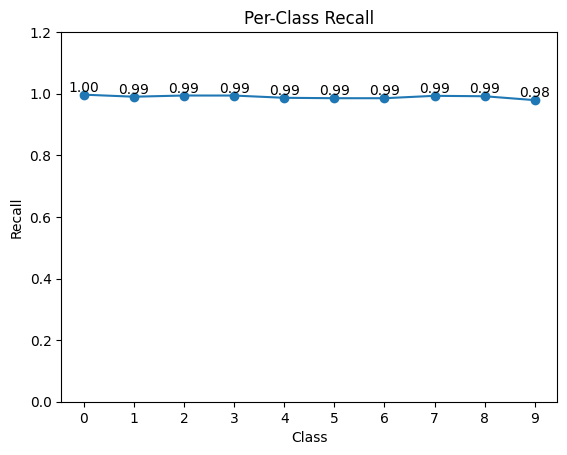

In [287]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

## Optmizers

- Adam -> Best run -> .9922 -> lr=0.001 -> keep this one
- SGD -> Higer Learning rates work better -> Best run -> .9883 -> lr=0.5
- RAdam -> Best run -> .9893 -> lr=0.001

### Training

In [348]:
#Instance of the model
model_le_final = LeNet_final(10)

#Comment the lines which you dont want to run

opt_final = Adam(model_le_final.parameters(), lr=0.001)
# opt_final = SGD(model_le_final.parameters(), lr=0.7)
# opt_final = RAdam(model_le_final.parameters(), lr=0.005)

loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_final = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)

In [349]:
losses_le_final = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_final:
    predictions = model_le_final(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_final.zero_grad()
    loss.backward()
    opt_final.step()

    losses_le_final.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 0.06548299640417099
Epoch 1: Loss = 0.06681712716817856
Epoch 2: Loss = 0.12390924245119095
Epoch 3: Loss = 0.09904975444078445
Epoch 4: Loss = 0.04446856677532196
Epoch 5: Loss = 0.07054906338453293
Epoch 6: Loss = 0.027309706434607506
Epoch 7: Loss = 0.00205865316092968
Epoch 8: Loss = 0.013103131204843521
Epoch 9: Loss = 0.01651591993868351


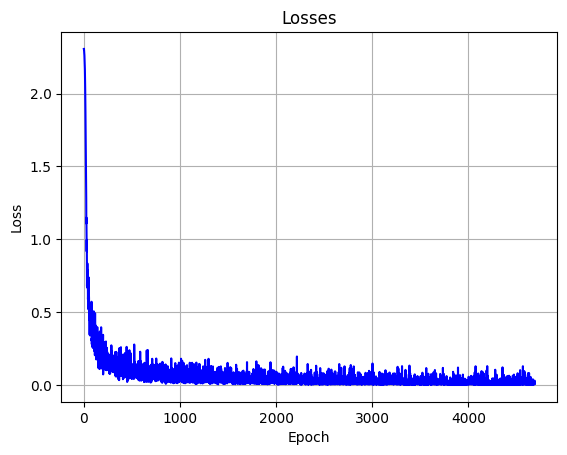

In [350]:
#Plot losses
plt.plot(losses_le_final, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [351]:
batch_size_test = 10000
test_loader = utils.data.DataLoader(mnist_test_28, batch_size=batch_size_test)

# Image tensor has shape (10000, 1, 28, 28)
imgs, labels = next(iter(test_loader))

# Calculates tahe results for all the images, returning us a tensor of shape (10000, 10)
# imgs[i][j] => i -> image; j -> the score for that number [0-1]
predictions = model_le_final(imgs)

# For each row determine the columns with the highest score, the prediction
predicted_classes = torch.argmax(predictions, dim=1)

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9903


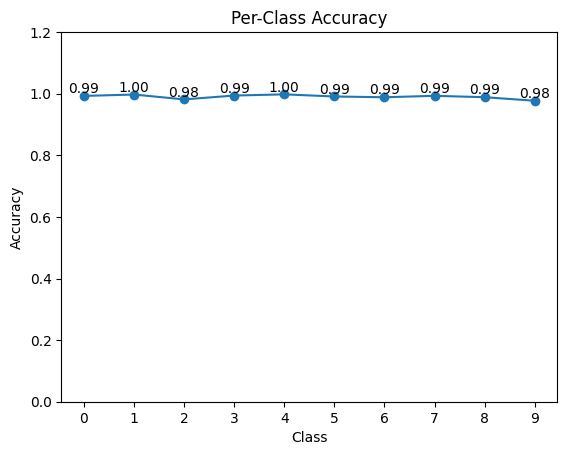

In [352]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision


In [353]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

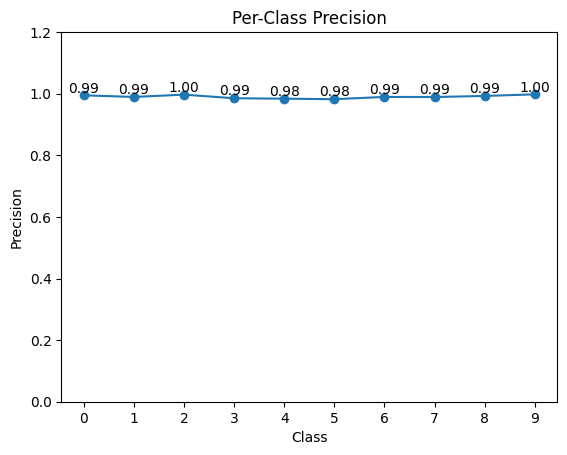

In [354]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall

In [305]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

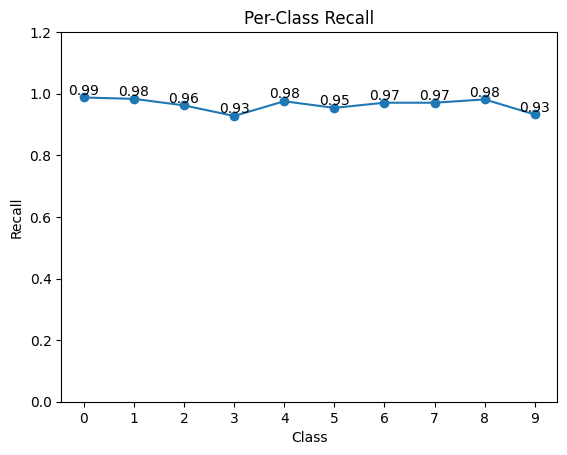

In [306]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

## Grid Search


In [393]:
def train_and_evaluate_model(num_epochs, batch_size):

    #model - dataloaders
    model = LeNet_final(10)
    train_loader = utils.data.DataLoader(mnist_training_28, batch_size=batch_size, shuffle=True)
    test_loader = utils.data.DataLoader(mnist_test_28, batch_size=10000)

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)

    # Training
    for _ in range(num_epochs):
        for imgs, labels in train_loader:
            predictions = model_le(imgs)
            loss = loss_fn(predictions, labels)

            # Backprop
            opt.zero_grad()
            loss.backward()
            opt.step()
    
    # Calculate the total accuracy
    imgs, labels = next(iter(test_loader))
    predictions = model_le(imgs)
    predicted_classes = torch.argmax(predictions, dim=1)
    total_accuracy = (predicted_classes == labels).float().mean().item()

    return total_accuracy


In [395]:
best_accuracy = 0.0
best_hyperparameters = {}

epochs_list = [10, 20, 30]
batch_sizes = [64, 128, 256, 512]

for num_epochs in epochs_list:
    for batch_size in batch_sizes:
        accuracy = train_and_evaluate_model(num_epochs, batch_size)
        print(f"Epochs: {num_epochs}, Batch Size: {batch_size}, Accuracy: {accuracy}")

        # Check if this configuration is better than the current best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = {
                'num_epochs': num_epochs,
                'batch_size': batch_size
            }


Epochs: 10, Batch Size: 64, Accuracy: 0.9900000095367432
Epochs: 10, Batch Size: 128, Accuracy: 0.9886999726295471
Epochs: 10, Batch Size: 256, Accuracy: 0.9890000224113464
Epochs: 10, Batch Size: 512, Accuracy: 0.9890999794006348
Epochs: 20, Batch Size: 64, Accuracy: 0.989300012588501
Epochs: 20, Batch Size: 128, Accuracy: 0.9898999929428101
Epochs: 20, Batch Size: 256, Accuracy: 0.9894999861717224
Epochs: 20, Batch Size: 512, Accuracy: 0.9897000193595886
Epochs: 30, Batch Size: 64, Accuracy: 0.9902999997138977
Epochs: 30, Batch Size: 128, Accuracy: 0.9905999898910522
Epochs: 30, Batch Size: 256, Accuracy: 0.9902999997138977
Epochs: 30, Batch Size: 512, Accuracy: 0.9901999831199646


In [398]:
print(f"Best Hyperparameters: {best_hyperparameters}")
print(f"Best Accuracy: {best_accuracy:.4f}")

Best Hyperparameters: {'num_epochs': 30, 'batch_size': 128}
Best Accuracy: 0.9906


# AlexNet


AlexNet was an evolution of LeNet, retaining the idea of multiple convolutional layers followed by fully connected layers. With increased computational capacity, AlexNet deepened and broadened the architecture, allowing timely training. It also introduced the relu activation function, which simplified training deep networks by requiring fewer mathematical operations. Additionally, max pooling was used instead of average pooling, leading to better feature comprehension. The incorporation of dropout, a regularization technique, further reduced overfitting by randomly deactivating neurons based on a probability, ensuring a more generalist model.

In [8]:
class AlexNet(nn.Module):

  def __init__ (self, num_classes):
    super().__init__()
    self.num_classes = num_classes

    self.net = nn.Sequential(
      nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
      nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
      nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
      nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
      nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
      nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
      nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
      nn.LazyLinear(num_classes)
    )

  def forward (self, x):
    return self.net(x)

In [11]:
model = AlexNet(10)
layer_summary(model.net, (1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

### Preparing

In [31]:
#Instance of the model
model_alex = AlexNet(10)
opt_alex = Adam(model_alex.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_alex = utils.data.DataLoader(mnist_training_224, batch_size=batch_size, shuffle=True)

/home/heitor/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

The process of training/testing was really long and tough, comparing to the other architechtures, there's just a little much to improve, so we are going to proceed in testing another alternatives for improvement of the results. Training a really wide + deep network in computers that weren't adequate isn't an easy task. 

Although we've had a lot of trouble training and testing, we've arrived to some results. The total accuracy was higher, but not significantly, some models can be easier to train and still have some great result withou all this pain

In [32]:
losses_al = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_alex:
    predictions = model_alex(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_alex.zero_grad()
    loss.backward()
    opt_alex.step()

    losses_al.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")


#saving the model to avoid further errors -> out of memory
with open('model_state.pt', 'wb') as f:
  save(model_alex.state_dict(), f)

Epoch 0: Loss = 0.08268454670906067
Epoch 1: Loss = 0.11645566672086716
Epoch 2: Loss = 0.013871601782739162
Epoch 3: Loss = 0.016680410131812096
Epoch 4: Loss = 0.030279777944087982
Epoch 5: Loss = 0.08899936825037003
Epoch 6: Loss = 0.007662383373826742
Epoch 7: Loss = 0.01114968117326498
Epoch 8: Loss = 0.001201842911541462
Epoch 9: Loss = 0.02312086522579193


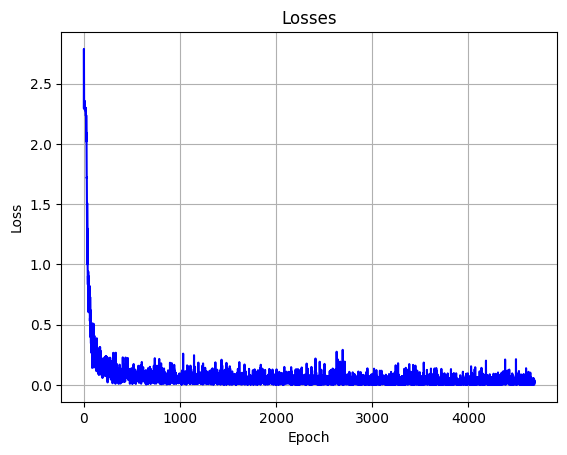

In [33]:
#Plot losses
plt.plot(losses_al, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [32]:
#getting the saved model from model_state
with open('model_state.pt', 'rb') as f:
    model_alex.load_state_dict(load(f))

### Accuracy

In [33]:
batch_size_test = 100
test_loader_alex = utils.data.DataLoader(mnist_test_224, batch_size=batch_size_test)

predicted_classes_list = []
labels_list = []

for imgs, labels in test_loader_alex:
    predictions = model_alex(imgs)
    predicted_classes_list.append(torch.argmax(predictions, dim=1))
    labels_list.append(labels)

predicted_classes = torch.cat(predicted_classes_list, dim=0)
labels = torch.cat(labels_list, dim=0)
   

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.9892


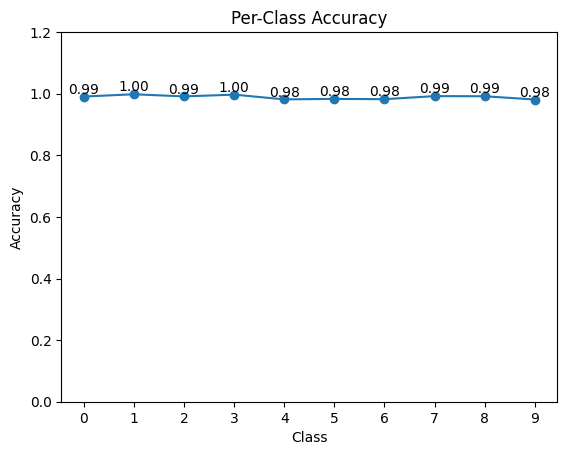

In [34]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision
Measures the accuracy of the positive predictions made by the model.

It can be described as: true positives / (true positives + false positives)

In [35]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

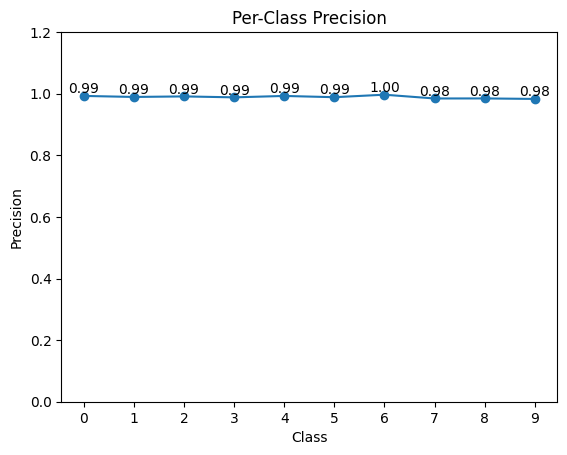

In [36]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall
Measures the ability of the model to predict positive samples correctly

It can be described as: true positives / (true positives + false negatives)

In [37]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

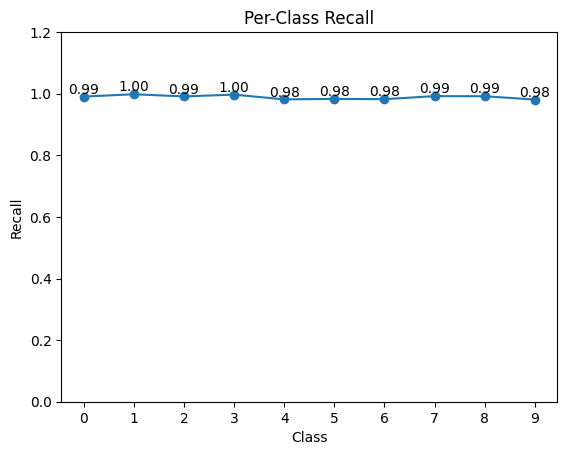

In [38]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

# NiN (Network in Network)

In [19]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU()
    )

In [20]:
class NiN(nn.Module):
    def __init__(self, lr=0.1, num_classes = 10):
        super().__init__()
        self.num_classes = num_classes

        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)


In [21]:
model_nin = NiN()
layer_summary(model_nin.net, (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


### Preparing

In [22]:
#Instance of the model
model_nin = NiN(lr=1e-3)
opt_nin = Adam(model_nin.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training with batches of 128 -> lower batch sizes showed many signals of overfitting
batch_size = 128
train_loader_nin = utils.data.DataLoader(mnist_training_224, batch_size=batch_size, shuffle=True)

### Training


In [23]:
losses_nin = []

for epoch in range(10): # Number of Epochs
  for imgs, labels in train_loader_nin:
    predictions = model_nin(imgs)
    loss = loss_fn(predictions, labels)

    # Backprop
    opt_nin.zero_grad()
    loss.backward()
    opt_nin.step()

    losses_nin.append(float(loss))
  print(f"Epoch {epoch}: Loss = {float(loss)}")

Epoch 0: Loss = 1.737493872642517
Epoch 1: Loss = 1.7368497848510742
Epoch 2: Loss = 1.8320798873901367
Epoch 3: Loss = 1.4606302976608276
Epoch 4: Loss = 1.3540290594100952
Epoch 5: Loss = 1.3025556802749634
Epoch 6: Loss = 1.6698065996170044
Epoch 7: Loss = 1.4461332559585571
Epoch 8: Loss = 1.3962665796279907
Epoch 9: Loss = 1.4569950103759766


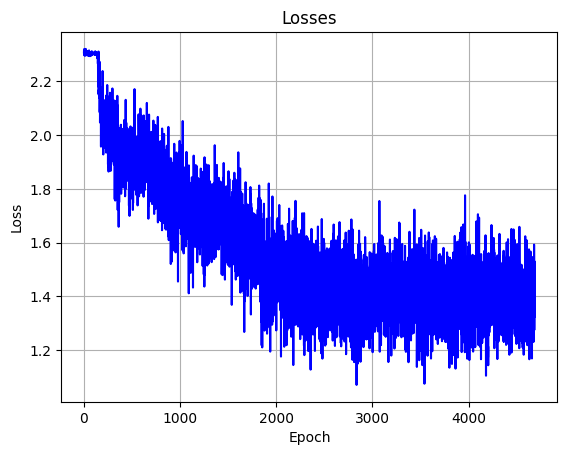

In [25]:
#Plot losses
plt.plot(losses_nin, linestyle='-', color='blue')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Accuracy

In [27]:
batch_size_test = 100
test_loader_nin = utils.data.DataLoader(mnist_test_224, batch_size=batch_size_test)

predicted_classes_list = []
labels_list = []

for imgs, labels in test_loader_nin:
    predictions = model_nin(imgs)
    predicted_classes_list.append(torch.argmax(predictions, dim=1))
    labels_list.append(labels)

predicted_classes = torch.cat(predicted_classes_list, dim=0)
labels = torch.cat(labels_list, dim=0)
   

#Calculate the multiclass accuracy
class_accuracy_metric = Accuracy(task='multiclass', num_classes=10, average=None)
class_accuracy_metric(predicted_classes, labels)
class_accuracy = class_accuracy_metric.compute()

# Calculate the total accuracy
total_accuracy = (predicted_classes == labels).float().mean().item()

print(f"Total Accuracy: {total_accuracy:.4f}")

Total Accuracy: 0.5050


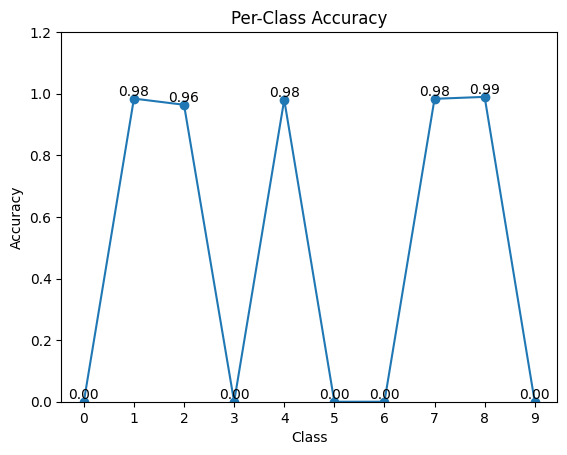

In [28]:
# Plotting the per-class accuracy
class_indices = range(10)

plt.plot(class_indices, class_accuracy, marker='o')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_accuracy):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Precision
Measures the accuracy of the positive predictions made by the model.

It can be described as: true positives / (true positives + false positives)

In [29]:
# Calculating the precision for each class
class_precision_metric = Precision(task='multiclass', num_classes=10, average=None)
class_precision_metric(predicted_classes, labels)
class_precision = class_precision_metric.compute()

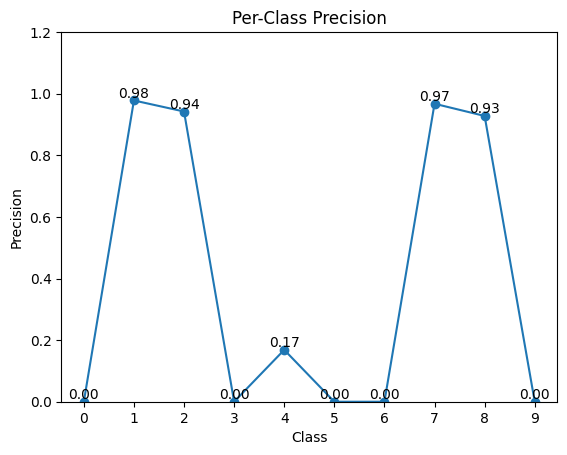

In [30]:
# Plotting the per-class precision
class_indices = range(10)

plt.plot(class_indices, class_precision, marker='o')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Per-Class Precision')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_precision):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

### Recall
Measures the ability of the model to predict positive samples correctly

It can be described as: true positives / (true positives + false negatives)

In [31]:
# Calculating the recall for each class
class_recall_metric = Recall(task='multiclass', num_classes=10, average=None)
class_recall_metric(predicted_classes, labels)
class_recall = class_recall_metric.compute()

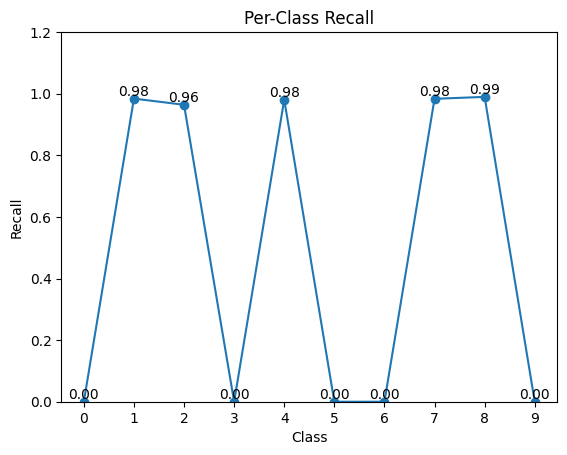

In [32]:
# Plotting the recall
class_indices = range(10)

plt.plot(class_indices, class_recall, marker='o')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Per-Class Recall')
plt.ylim(0, 1.2)
plt.xticks(class_indices)

# Add labels to each marker
for x, y in zip(class_indices, class_recall):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

# References

This notebook is based on the books:

"Dive into deep learning" by Aston Zhang, Zack C. Lipton, Mu Li and Alex J. Smola.

"Neural Networks and Deep Learning" by Michael Nielsen.